In [8]:
import os
import sys
sys.path.append(os.path.split(os.path.abspath(''))[0])

In [137]:
import pandas as pd
import numpy as np
import datetime

import matplotlib as mpl
import matplotlib.pyplot as plt

In [10]:
import Database as dbf
import config as c
import utils.times as times

In [11]:
btc_1m_path = os.path.join(c.database_folder_path, 'BTCUSD_1m.db')
btc_1m_table_name = 'BTCUSD_1m'

In [12]:
with dbf.create_connection(btc_1m_path) as con:
    print(dbf.query_table_column_names(con, btc_1m_table_name))
    df = dbf.query_entire_table(con, btc_1m_table_name)
    

Connected at: C:\Users\riggi\Data\Crypto_Day_Trading\BTCUSD_1m.db
TRYING TO QUERY:  SELECT c.name FROM pragma_table_info('BTCUSD_1m') c;
['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume']
TRYING TO QUERY:  SELECT c.name FROM pragma_table_info('BTCUSD_1m') c;
TRYING TO QUERY:  SELECT * FROM BTCUSD_1m


In [13]:
df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume'],
      dtype='object')

In [14]:
1689303540000

1689303540000

In [15]:
import datetime
dt = datetime.datetime(2021, 11, 10, tzinfo=datetime.timezone.utc)
ath_time = (dt.replace(tzinfo=datetime.timezone.utc).timestamp() * 1000)

In [17]:
max(df['open_time'].values)

1689303540000

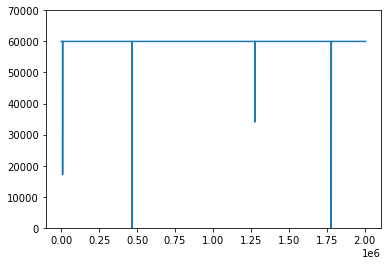

[4.3, 9.016666666666667, 10.016666666666667, 3.05, 3.5166666666666666, 7.766666666666667, 0.5833333333333334, 6.816666666666666, 0.36666666666666664]


In [18]:
#plt.plot(np.diff(df['open_time'].values))
plt.plot(df['close_time']-df['open_time'])
plt.ylim(0, 70000)
plt.show()
print([float(x/60000)/60.0 for x in np.diff(df['open_time'].values) if x != 60000])

### Mess Around With EMA Calculation

In [31]:
def ema_candlestick(data, span, func=lambda x: x.mean()):
    # Calculates an EMA from a pandas series
    # https://pandas.pydata.org/pandas-docs/version/0.17.0/generated/pandas.ewma.html
    # NOTE: It seems like in charting the closing price is usually used for EMA
    
    # data: Pandas Series
    # Span: Integer
    
    adjust=False
    return func(pd.Series.ewm(data, span, adjust=adjust))

In [32]:
def macd_candlestick(data, long_span=26, short_span=12, signal_span=9, func=lambda x: x.mean()):
    
    # https://www.investopedia.com/terms/m/macd.asp#:~:text=MACD%20is%20calculated%20by%20subtracting,the%20exponentially%20weighted%20moving%20average.
    
    # data: Pandas Series
    # long_span: Integer
    # short_span: Integer
    # signal_span: Integer
    
    long_span_ema = ema_candlestick(data, span=long_span)
    print(long_span_ema)
    short_span_ema = ema_candlestick(data, span=short_span)
    macd, signal = macd_from_ema_candlestick(long_span_ema, short_span_ema, signal_span)
    return macd, signal
    
def macd_from_ema_candlestick(long_span_ema, short_span_ema, signal_span=9):
    macd = short_span_ema - long_span_ema
    signal = ema_candlestick(macd, signal_span)
    return macd, signal

In [46]:
closing_series = df['close']

macd, signal = macd_candlestick(closing_series)
df['macd'] = macd
df['signal'] = signal
df['10EMA'] = ema_candlestick(closing_series, 10)
df['50EMA'] = ema_candlestick(closing_series, 50)
df['100EMA'] = ema_candlestick(closing_series, 100)

0          10170.000000
1          10170.000000
2          10170.000000
3          10170.000000
4          10170.000000
               ...     
2007081    25311.950237
2007082    25299.631709
2007083    25285.571276
2007084    25277.030858
2007085    25269.481937
Name: close, Length: 2007086, dtype: float64


In [47]:
ath_time

1636502400000.0

In [48]:
# df_mini = df[np.logical_and(df['open_time'] >= ath_time-(860400000*3),
#                            df['open_time'] <= ath_time+(860400000*3))]


jan_12_2023_start = 1673499600000
jan_12_2023_end = 1673586000000
df_mini = df[np.logical_and(df['open_time'] >= jan_12_2023_start,
                           df['open_time'] <= jan_12_2023_end)]

print(df_mini.columns)

x = df_mini['close_time'].values
#y = np.mean(np.array([df['open'].values, df['close'].values]), axis=0)[-10000:]
y = df_mini['high'].values
macd = df_mini['macd']
signal = df_mini['signal']
ema_10 = df_mini['10EMA']
ema_50 = df_mini['50EMA']
ema_100 = df_mini['100EMA']

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'macd', 'signal', '10EMA', '50EMA',
       '100EMA'],
      dtype='object')


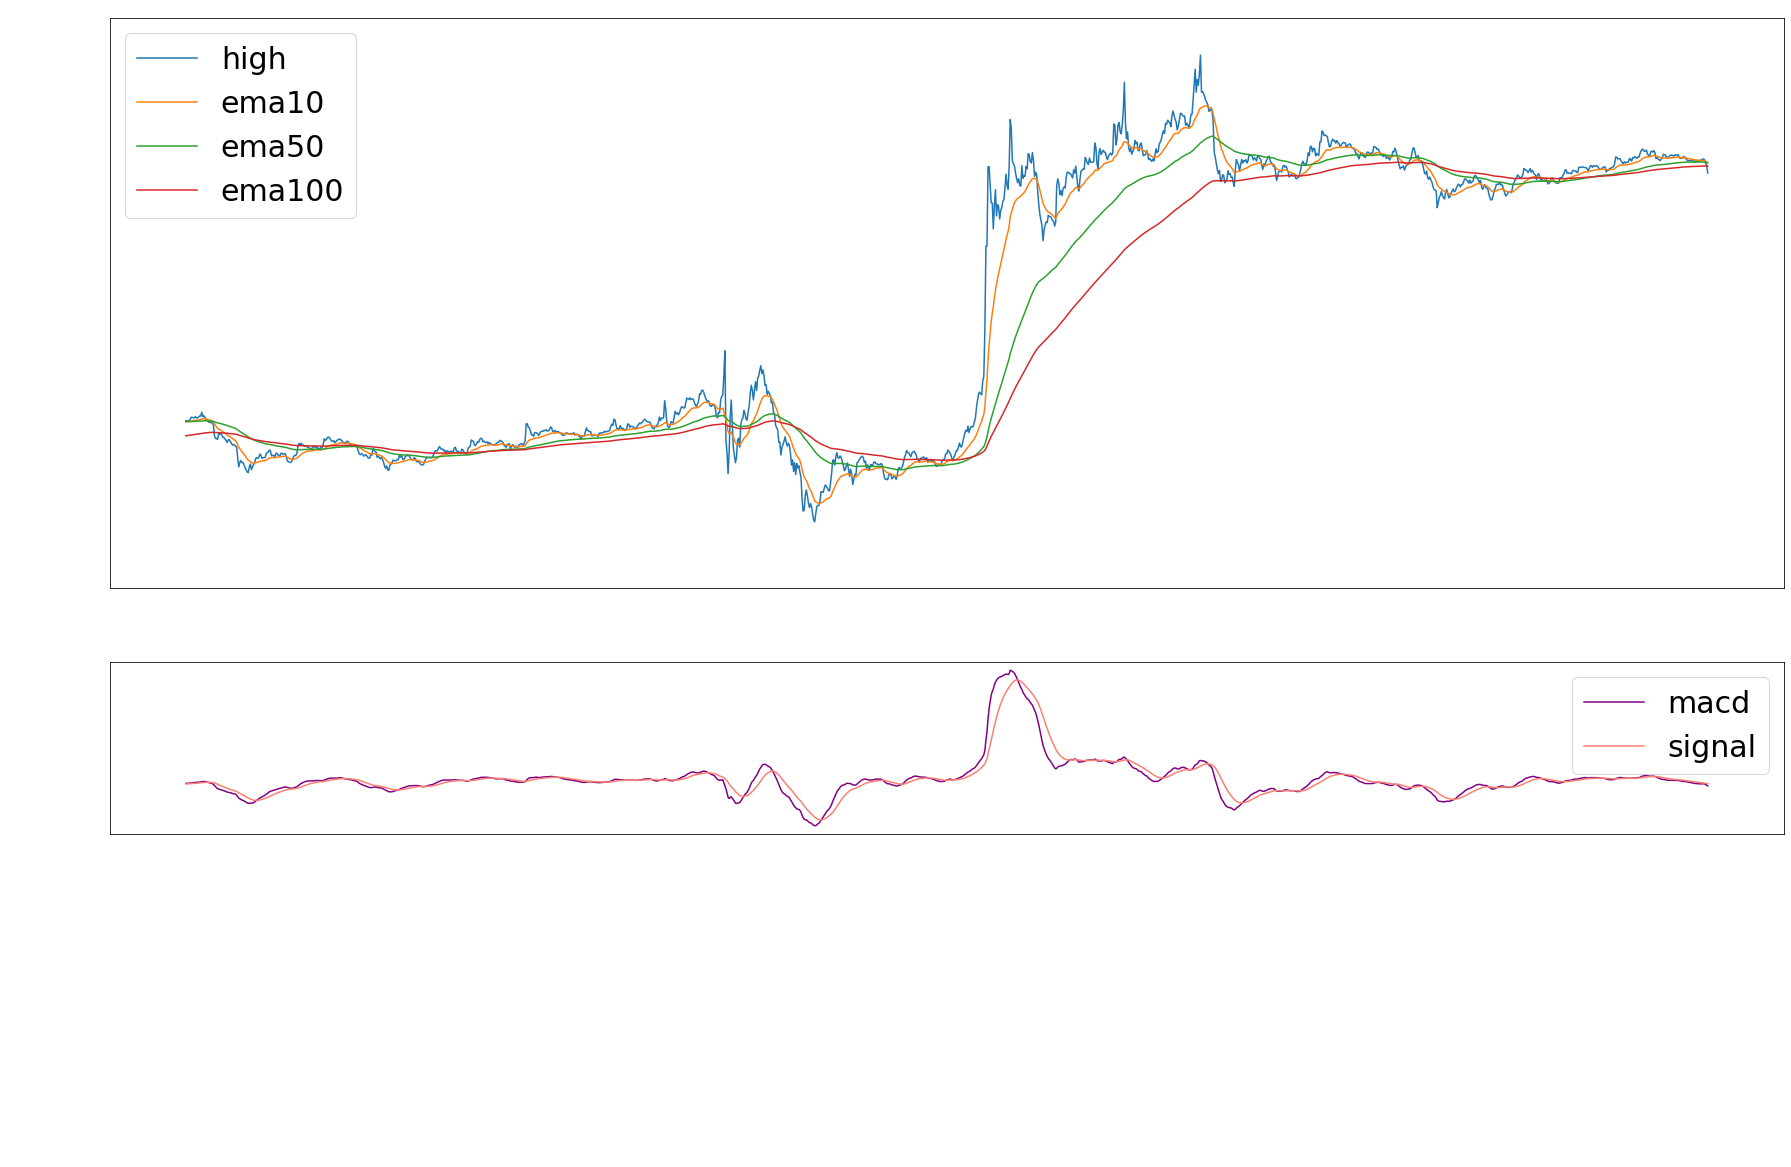

In [76]:
mpl.rcParams['ytick.color'] = 'white'
mpl.rcParams['xtick.color'] = 'white'

fig, axs = plt.subplots(nrows=2, sharex=True, gridspec_kw={'height_ratios':[10,3]}, figsize=(30,15))
axs[0].plot(x, y, label='high')
axs[0].plot(x, ema_10, label='ema10')
axs[0].plot(x, ema_50, label='ema50')
axs[0].plot(x, ema_100, label='ema100')
plt.draw()
xlabs = [str(times.unix_to_datetime(z.get_position()[0])) for z in plt.gca().get_xticklabels()]
xlablocs = plt.xticks()[0]
plt.sca(axs[0])
plt.xticks(xlablocs, xlabs, rotation=90, fontsize=30)
plt.yticks(plt.yticks()[0], plt.yticks()[1], rotation=0, fontsize=30)
plt.sca(axs[1])
plt.yticks(fontsize=30)
plt.xticks(xlablocs, xlabs, rotation=90, fontsize=30)
#plt.yticks(plt.yticks()[0], plt.yticks()[1], rotation=0, fontsize=30)


axs[1].plot(x, macd, label='macd', color='purple')
axs[1].plot(x, signal, label='signal', color='salmon')
#plt.axhline(68649.05)
#plt.axvline(ath_time)
axs[0].legend(fontsize=30)
axs[1].legend(fontsize=30)
plt.show()

In [119]:
def cross_above_flags(sigA,sigB):
    if isinstance(sigA, pd.Series):
        sigA = sigA.values
    if isinstance(sigB, pd.Series):
        sigB = sigB.values
    flags = []
    assert(len(sigA)==len(sigB))
    for i in range(len(sigA)):
        if i != 0 and (sigA[i-1] < sigB[i-1] and sigA[i] >= sigB[i]):
            flags.append(True)
        else:
            flags.append(False)
    return flags

def calc_rsi(sig, span=14):
    from copy import copy
    if not isinstance(sig, pd.Series):
        sig = pd.Series(sig)
    change = sig.diff()
    change.dropna(inplace=True)
    change_up = change.copy()
    change_down = change.copy()
    
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0

    # Verify that we did not make any mistakes
    assert(change.equals(change_up+change_down))

    # Calculate the rolling average of average up and average down
    avg_up = change_up.rolling(span).mean()
    avg_down = change_down.rolling(span).mean().abs()
    
    rsi = 100 * avg_up / (avg_up + avg_down)
    
    return rsi

In [120]:
df.columns

Index(['open_time', 'open', 'high', 'low', 'close', 'volume', 'close_time',
       'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume',
       'taker_buy_quote_asset_volume', 'macd', 'signal', '10EMA', '50EMA',
       '100EMA', 'macd_cross_signal', '10ema_cross_100ema'],
      dtype='object')

In [142]:
def datetime_to_unix(dt):
    import datetime
    utc_time = dt.replace(tzinfo=datetime.timezone.utc)
    return round(utc_time.timestamp() * 1000)

print(datetime_to_unix(datetime.datetime(2023, 1, 12)))
print(datetime_to_unix(datetime.datetime(2023, 1, 13)))

1673481600000
1673568000000


In [145]:
sd = datetime_to_unix(datetime.datetime(2023, 2, 12))
ed = datetime_to_unix(datetime.datetime(2023, 2, 13))

df_mini = df[np.logical_and(df['open_time'] >= sd,
                           df['open_time'] <= ed)]

closing_seried = df_mini['close']
macd, signal = macd_candlestick(closing_series)
x = df_mini['close_time'].values
#y = np.mean(np.array([df['open'].values, df['close'].values]), axis=0)[-10000:]
y = df_mini['high'].values
df_mini['macd'] = macd
df_mini['signal'] = signal
df_mini['10EMA'] = ema_candlestick(closing_series, 10)
df_mini['50EMA'] = ema_candlestick(closing_series, 50)
df_mini['100EMA'] = ema_candlestick(closing_series, 100)

df_mini['macd_cross_signal'] = cross_above_flags(df_mini['macd'].values, df_mini['signal'].values)
df_mini['10ema_cross_100ema'] = cross_above_flags(df_mini['10EMA'].values, df_mini['100EMA'].values)
df_mini['rsi'] = calc_rsi(df_mini['close'], span=26)


macd = df_mini['macd']
signal = df_mini['signal']
ema_10 = df_mini['10EMA']
ema_50 = df_mini['50EMA']
ema_100 = df_mini['100EMA']
macd_cross =  df_mini['macd_cross_signal'].values
ema_cross = df_mini['10ema_cross_100ema'].values
rsi = df_mini['rsi'].values

0          10170.000000
1          10170.000000
2          10170.000000
3          10170.000000
4          10170.000000
               ...     
2007081    25311.950237
2007082    25299.631709
2007083    25285.571276
2007084    25277.030858
2007085    25269.481937
Name: close, Length: 2007086, dtype: float64


<ipython-input-145-1e796bdc3191>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mini['macd'] = macd
<ipython-input-145-1e796bdc3191>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_mini['signal'] = signal
<ipython-input-145-1e796bdc3191>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#re

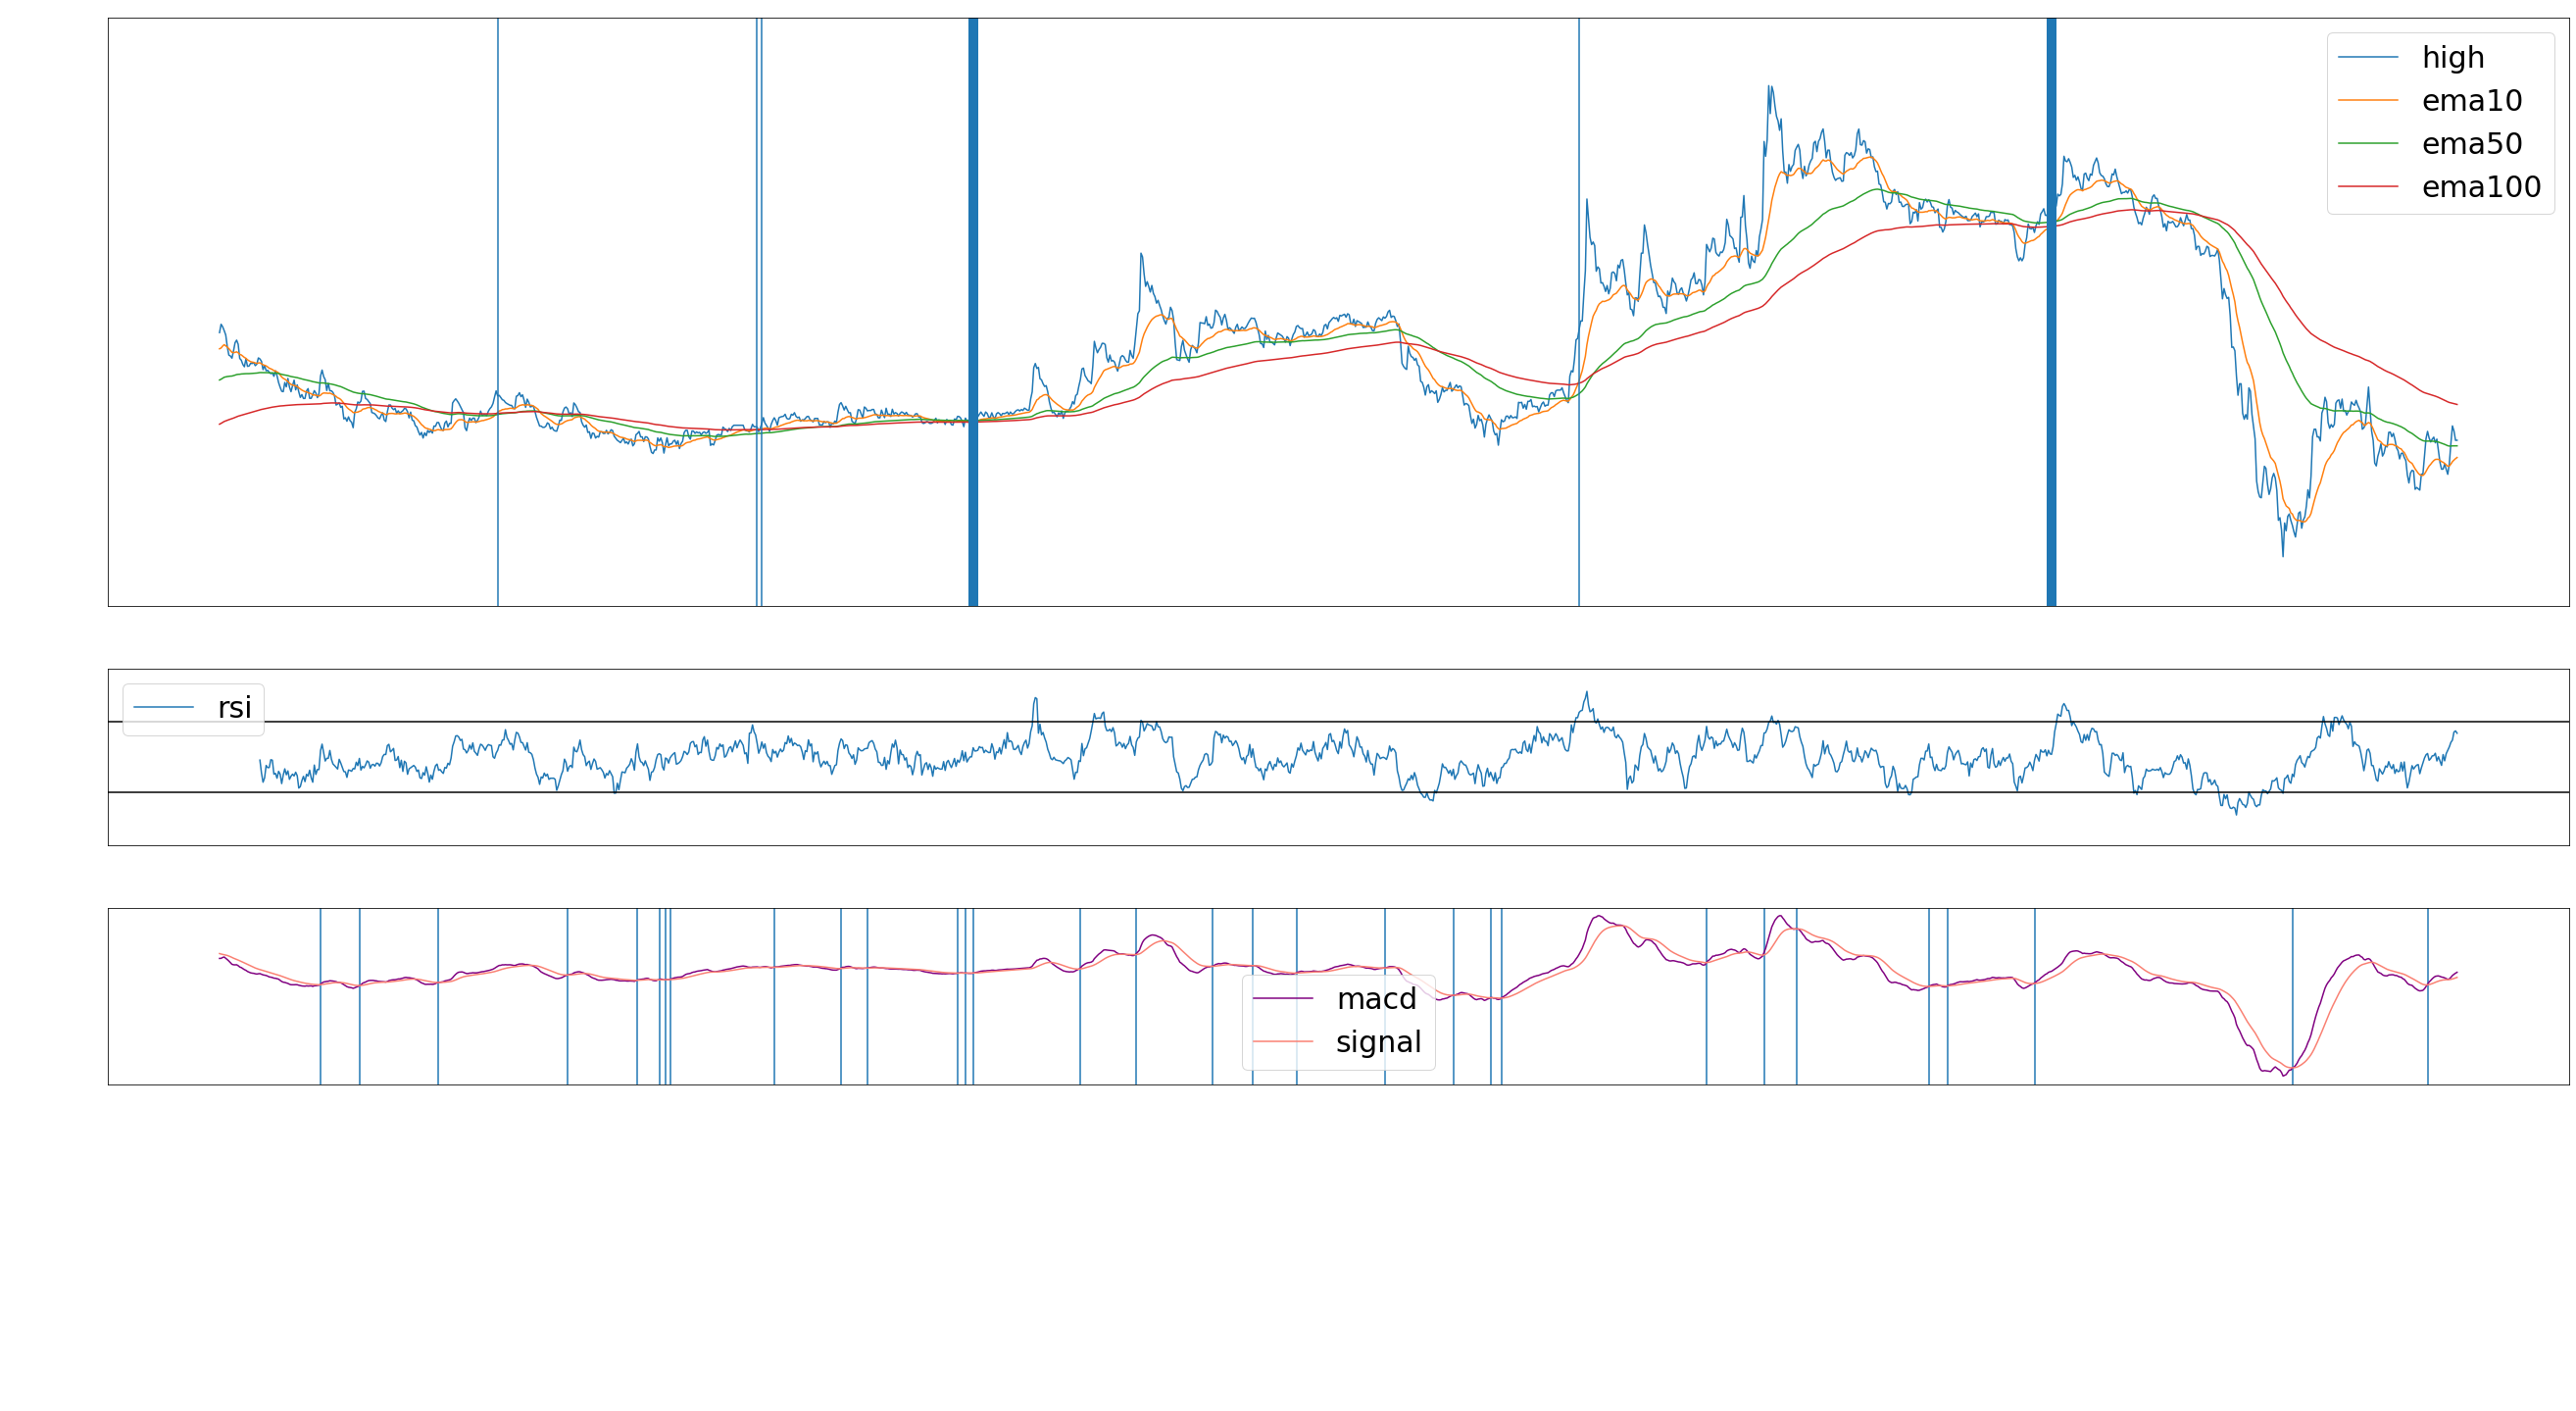

In [146]:
macd_cross_to_ema_cross = 30

fig, axs = plt.subplots(nrows=3, sharex=True, gridspec_kw={'height_ratios':[10,3,3]}, figsize=(45,20))
axs[0].plot(x, y, label='high')
axs[0].plot(x, ema_10, label='ema10')
axs[0].plot(x, ema_50, label='ema50')
axs[0].plot(x, ema_100, label='ema100')
plt.draw()
xlabs = [str(times.unix_to_datetime(z.get_position()[0])) for z in plt.gca().get_xticklabels()]
xlablocs = plt.xticks()[0]
plt.sca(axs[0])
plt.xticks(xlablocs, xlabs, rotation=90, fontsize=30)
plt.yticks(plt.yticks()[0], plt.yticks()[1], rotation=0, fontsize=30)
for i in range(len(ema_cross)):
    if(ema_cross[i]):
        plt.axvline(x[i])
        for j in range(1, 1+macd_cross_to_ema_cross):
                if i-j>=0 and macd_cross[i-j]:
                    plt.axvline(x[i], linewidth=10)
        
        
plt.sca(axs[1])
plt.yticks(fontsize=30)
plt.xticks(xlablocs, xlabs, rotation=90, fontsize=30)  
axs[1].plot(x, rsi, label='rsi')
axs[1].set_ylim((0,100))
plt.axhline(30, color='black')
plt.axhline(70, color='black')
    
        
plt.sca(axs[2])
plt.yticks(fontsize=30)
plt.xticks(xlablocs, xlabs, rotation=90, fontsize=30)
for i in range(len(macd_cross)):
    if(macd_cross[i]):
        plt.axvline(x[i])
#plt.yticks(plt.yticks()[0], plt.yticks()[1], rotation=0, fontsize=30)


axs[2].plot(x, macd, label='macd', color='purple')
axs[2].plot(x, signal, label='signal', color='salmon')
#plt.axhline(68649.05)
#plt.axvline(ath_time)
axs[0].legend(fontsize=30)
axs[1].legend(fontsize=30)
axs[2].legend(fontsize=30)
plt.show()